In [1]:
%pylab inline
import numpy as np
import torch
import os

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import dataloader

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST

from sklearn.metrics import accuracy_score
from collections import deque

from graphviz import Digraph

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE = 768

# Data

In [3]:
train = FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE ,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

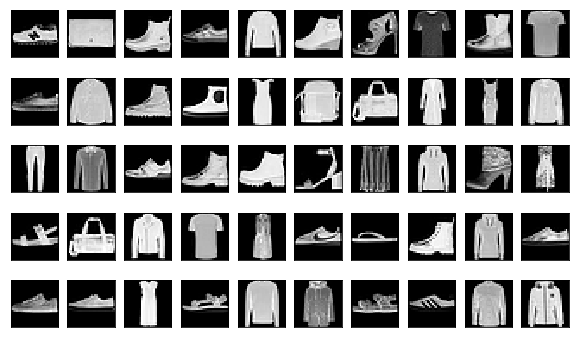

In [4]:
def visualize_data(data):
    N = data.size()[0]
    
    fig, subplots = plt.subplots(5, 10)
    fig.set_figheight(6)
    fig.set_figwidth(10)
    subplots = subplots.reshape(-1)
    
    for subplot in subplots:
        idx = np.random.randint(0, N)
        img = train.train_data[idx].numpy()
        
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(img, cmap='gray')
        
visualize_data(train.train_data)

# Model

## Discriminator

In [5]:
np.random.seed(0)
torch.manual_seed(0)

class Discriminator(nn.Module):
    def __init__(self, channel:int=256):
        super(Discriminator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        
        self.channel:int = channel
        n_class:int = 1 # 1=진짜, 0=가짜 이기 때문에 1값으로 둔다.
        
        self.conv1 = nn.Conv2d(1, channel//4, kernel_size=6, stride=1, padding=2)
        self.conv2 = nn.Conv2d(channel//4, channel//3, kernel_size=5, stride=2, padding=4)
        self.bn2 = nn.BatchNorm2d(channel//3)
        self.conv3 = nn.Conv2d(channel//3, channel//2, kernel_size=4, stride=2, padding=4)
        self.bn3 = nn.BatchNorm2d(channel//2)
        self.conv4 = nn.Conv2d(channel//2, channel, kernel_size=4, stride=2, padding=4)
        self.bn4 = nn.BatchNorm2d(channel)
        
        # Global Average Pooling
        self.conv5 = nn.Conv2d(channel, n_class, kernel_size=4, stride=2, padding=4)

    def forward(self, x, _return_activations=False):
        h1: Variable = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        h2: Variable = F.leaky_relu(self.bn2(self.conv2(h1)), negative_slope=0.2)
        h3: Variable = F.leaky_relu(self.bn3(self.conv3(h2)), negative_slope=0.2)
        h4: Variable = F.leaky_relu(self.bn4(self.conv4(h3)), negative_slope=0.2)
        
        # Global Average Pooling
        h5 = F.leaky_relu(self.conv5(h4), negative_slope=0.2)
        gap = F.avg_pool2d(h5, kernel_size=h5.size()[2:]).view(h5.size()[0], -1)
        output = F.sigmoid(gap)
        
        if _return_activations:
            return output, [h1, h2, h3, h4, h5, gap]
        
        return output
    
    def feature_mapping(self, real, fake):
        _, real_fs = self.forward(real, _return_activations=True)
        _, fake_fs = self.forward(fake, _return_activations=True)
        real = real_fs
        fake = fake_fs
        
        diffs = []
        for real, fake in zip(real_fs, fake_fs):
            diff = torch.sqrt(torch.mean(torch.pow(real - fake, 2)))
            diffs.append(diff)
        
        output = torch.mean(torch.stack(diffs))
        
#         print('x'*50)
#         output.backward()
#         print(fake.grad_fn)
#         print(dir(fake.grad_fn.next_functions[0][0]))
        return output
        
D = Discriminator()
print(D.cuda()) # CUDA!
d_optimizer = optim.Adam(D.parameters(), lr=0.001)



# g_optimizer.zero_grad()
# real = real_images[0:2]
# noise = Variable(torch.randn((2, 100, 1, 1)).cuda())
# fake = G(noise)
# D.improved_loss(real, fake)

# D.feature_mapping(real, fake)
# print()

Discriminator(
  (conv1): Conv2d (1, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d (64, 85, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
  (bn2): BatchNorm2d(85, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d (85, 128, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d (256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(4, 4))
)


## Generator

In [6]:
np.random.seed(0)
torch.manual_seed(0)

class Generator(nn.Module):
    def __init__(self, noise:int=100, channel:int=64):
        super(Generator, self).__init__()
        np.random.seed(0)
        torch.manual_seed(0)
        _c = channel
        
        self.noise = noise
        self.tp_conv1 = nn.ConvTranspose2d(noise, _c*16, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(_c*16)
        
        self.tp_conv2 = nn.ConvTranspose2d(_c*16, _c*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(_c*8)
        
        self.tp_conv3 = nn.ConvTranspose2d(_c*8, _c*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(_c*4)
        
        self.tp_conv4 = nn.ConvTranspose2d(_c*4, _c*2, kernel_size=4, stride=1, padding=2, bias=False)
        self.bn4 = nn.BatchNorm2d(_c*2)
        
        self.tp_conv5 = nn.ConvTranspose2d(_c*2, _c, kernel_size=4, stride=2, padding=2, bias=False)
        self.bn5 = nn.BatchNorm2d(_c)
        
        self.tp_conv6 = nn.ConvTranspose2d(_c, 1, kernel_size=5, stride=1, padding=2, bias=False)
    
    def forward(self, noise):
        noise = noise.view(-1, 100, 1, 1)
        h = self.tp_conv1(noise)
        h = F.relu(self.bn1(h))
#         print('h1', h.size())
        
        h = self.tp_conv2(h)
        h = F.relu(self.bn2(h))
#         print('h2', h.size())
        
        h = self.tp_conv3(h)
        h = F.relu(self.bn3(h))
#         print('h3', h.size())
        
        h = self.tp_conv4(h)
        h = F.relu(self.bn4(h))
#         print('h4', h.size())
        
        h = self.tp_conv5(h)
        h = F.relu(self.bn5(h))
#         print('h5', h.size())
        
        h = self.tp_conv6(h)
        h = F.sigmoid(h)
#         print('h6', h.size())
        return h
    

G = Generator()
print(G.cuda())
g_optimizer = optim.Adam(G.parameters(), lr=0.001)

Generator(
  (tp_conv1): ConvTranspose2d (100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv2): ConvTranspose2d (1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv3): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv4): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv5): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (tp_conv6): ConvTranspose2d (64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
)


# Checkpoint Functions

## Load Model

In [7]:
def load_model(filename, G, D, g_optimizer, d_optimizer):
    checkpoint = torch.load(filename)
    G.load_state_dict(checkpoint['G'])
    D.load_state_dict(checkpoint['D'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer'])
    divergences = checkpoint['divergence']
    d_losses = checkpoint['d_losses']
    g_losses = checkpoint['g_losses']
    d_fake_losses = checkpoint['d_fake_losses']
    d_real_losses = checkpoint['d_real_losses']
    return checkpoint, divergences, d_losses, g_losses, d_fake_losses, d_real_losses
    
# checkpoint, divergences, d_losses, g_losses, d_fake_losses, d_real_losses = load_model(
#     'checkpoints/anogan_999_0.8857.pth.tar', G, D, g_optimizer, d_optimizer)

## Save Model

In [8]:
def save_moodel(filename='anogan', epoch:int=None, divergence:float=None):
    if not os.path.exists('./checkpoints'):
        os.mkdir('./checkpoints')
        
    check_point = {'G': G.state_dict(), 
                   'D': D.state_dict(), 
                   'g_optimizer': g_optimizer.state_dict(),
                   'd_optimizer': d_optimizer.state_dict(),
                   'divergence': divergences, 
                   'd_losses': d_losses, 
                   'g_losses': g_losses, 
                   'd_fake_losses': d_fake_losses, 
                   'd_real_losses': d_real_losses}
    f_name = f'checkpoints/{filename}' 
    if epoch is not None:
        f_name += f'_{epoch}'
    if divergence is not None:
        f_name += f'_{divergence:<.4}'
    f_name += '.pth.tar'
    torch.save(check_point, f_name)
    print(f'checkpoint >> {f_name}')
# save_moodel()

# Training

In [9]:
N_EPOCH = 1000

real_y = Variable(torch.ones((BATCH_SIZE, 1)).cuda())
fake_y = Variable(torch.zeros((BATCH_SIZE, 1)).cuda())
loss_f = nn.BCELoss()

d_real_losses = list()
d_fake_losses = list()
d_losses = list()
g_losses = list()
divergences = list()

In [10]:
# Train Discriminator with Generator not being trained
# 먼저 Discriminator를 학습시킵니다.
# 이때 real image와 fake이미지 두개의 데이터를 사용하여 학습합니다. 
# Discriminator를 학습시킬때는 Generator는 학습시키면 안됩니다.
for epoch in range(N_EPOCH):
    for step, (real_images, _) in enumerate(train_loader):
        # Samples
        _batch_size = real_images.size(0)
        real_images = Variable(real_images.cuda())
        z = Variable(torch.randn((_batch_size, 100)).cuda())
                
        ###############################################
        # Train D (But do not train G)
        ###############################################
        # Init D
        d_optimizer.zero_grad()
        
        # Calculate the loss with real images
        y_real_pred = D(real_images)
        d_real_loss = loss_f(y_real_pred, real_y[:_batch_size])
        
        # Calculate the loss with fake images
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        y_fake_pred = D(G(noise).detach())
        d_fake_loss = loss_f(y_fake_pred, fake_y[:_batch_size])
        
        # Update D with G not being updated        
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        ###############################################
        # Train G with fake images but do not train G
        ###############################################
        g_optimizer.zero_grad()
        
        noise = Variable(torch.randn((_batch_size, 100, 1, 1)).cuda())
        
        g_loss = D.feature_mapping(real_images, G(noise))
        g_loss.backward()
        g_optimizer.step()
        
        ###############################################
        # Visualization
        ###############################################
        if step%5 == 0:
            d_real_losses.append(d_real_loss.data[0])
            d_fake_losses.append(d_fake_loss.data[0])
            d_losses.append(d_loss.data[0])
            g_losses.append(g_loss.data.cpu().numpy()[0])

            divergences.append(torch.mean(y_real_pred/(y_real_pred+y_fake_pred)).data[0])
        
        if step % 50 == 0:
            print(f'\r[{epoch+1}/{N_EPOCH}]',
                  # '{:.3}'.format(torch.mean(params[0]).data[0]),
                  'divergence: {:<8.3}'.format(np.mean(divergences[-100:])),
                  'D: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'D_real: {:<8.3}'.format(np.mean(d_real_losses[-100:])),
                  'D_fake: {:<8.3}'.format(np.mean(d_fake_losses[-100:])), 
                  'G:{:<8.3}'.format(np.mean(g_losses[-100:])), end='')
            
    print()
    save_moodel(epoch=epoch, divergence=np.mean(divergences[-100:]))
    print()

[1/1000] divergence: 0.93     D: 0.0823   D_real: 0.151    D_fake: 0.0823   G:4.68    
checkpoint >> checkpoints/anogan_0_0.9128.pth.tar

[2/1000] divergence: 0.887    D: 0.202    D_real: 0.102    D_fake: 0.202    G:4.59    
checkpoint >> checkpoints/anogan_1_0.8855.pth.tar

[3/1000] divergence: 0.893    D: 0.171    D_real: 0.153    D_fake: 0.171    G:4.49    
checkpoint >> checkpoints/anogan_2_0.8975.pth.tar

[4/1000] divergence: 0.899    D: 0.156    D_real: 0.15     D_fake: 0.156    G:4.5     
checkpoint >> checkpoints/anogan_3_0.9019.pth.tar

[5/1000] divergence: 0.893    D: 0.167    D_real: 0.141    D_fake: 0.167    G:4.46    
checkpoint >> checkpoints/anogan_4_0.8946.pth.tar

[6/1000] divergence: 0.899    D: 0.156    D_real: 0.131    D_fake: 0.156    G:4.48    
checkpoint >> checkpoints/anogan_5_0.8999.pth.tar

[7/1000] divergence: 0.901    D: 0.152    D_real: 0.128    D_fake: 0.152    G:4.56    
checkpoint >> checkpoints/anogan_6_0.9021.pth.tar

[8/1000] divergence: 0.915    D: 0

[60/1000] divergence: 0.856    D: 0.228    D_real: 0.203    D_fake: 0.228    G:3.91    
checkpoint >> checkpoints/anogan_59_0.8581.pth.tar

[61/1000] divergence: 0.86     D: 0.22     D_real: 0.204    D_fake: 0.22     G:3.89    
checkpoint >> checkpoints/anogan_60_0.8597.pth.tar

[62/1000] divergence: 0.863    D: 0.199    D_real: 0.203    D_fake: 0.199    G:3.85    
checkpoint >> checkpoints/anogan_61_0.8622.pth.tar

[63/1000] divergence: 0.867    D: 0.191    D_real: 0.195    D_fake: 0.191    G:3.77    
checkpoint >> checkpoints/anogan_62_0.8618.pth.tar

[64/1000] divergence: 0.861    D: 0.206    D_real: 0.178    D_fake: 0.206    G:3.83    
checkpoint >> checkpoints/anogan_63_0.8583.pth.tar

[65/1000] divergence: 0.863    D: 0.206    D_real: 0.178    D_fake: 0.206    G:3.88    
checkpoint >> checkpoints/anogan_64_0.8674.pth.tar

[66/1000] divergence: 0.884    D: 0.166    D_real: 0.179    D_fake: 0.166    G:4.1     
checkpoint >> checkpoints/anogan_65_0.8828.pth.tar

[67/1000] divergence

[176/1000] divergence: 0.815    D: 0.271    D_real: 0.285    D_fake: 0.271    G:3.46    
checkpoint >> checkpoints/anogan_175_0.8168.pth.tar

[177/1000] divergence: 0.808    D: 0.286    D_real: 0.297    D_fake: 0.286    G:3.48    
checkpoint >> checkpoints/anogan_176_0.803.pth.tar

[178/1000] divergence: 0.81     D: 0.277    D_real: 0.329    D_fake: 0.277    G:3.47    
checkpoint >> checkpoints/anogan_177_0.8119.pth.tar

[179/1000] divergence: 0.81     D: 0.28     D_real: 0.31     D_fake: 0.28     G:3.53    
checkpoint >> checkpoints/anogan_178_0.8137.pth.tar

[180/1000] divergence: 0.812    D: 0.298    D_real: 0.247    D_fake: 0.298    G:3.61    
checkpoint >> checkpoints/anogan_179_0.8113.pth.tar

[181/1000] divergence: 0.819    D: 0.276    D_real: 0.273    D_fake: 0.276    G:3.6     
checkpoint >> checkpoints/anogan_180_0.8257.pth.tar

[182/1000] divergence: 0.829    D: 0.257    D_real: 0.286    D_fake: 0.257    G:3.59    
checkpoint >> checkpoints/anogan_181_0.8274.pth.tar

[183/10

[234/1000] divergence: 0.826    D: 0.274    D_real: 0.31     D_fake: 0.274    G:3.53    
checkpoint >> checkpoints/anogan_233_0.8299.pth.tar

[235/1000] divergence: 0.83     D: 0.276    D_real: 0.313    D_fake: 0.276    G:3.57    
checkpoint >> checkpoints/anogan_234_0.8335.pth.tar

[236/1000] divergence: 0.834    D: 0.268    D_real: 0.288    D_fake: 0.268    G:3.62    
checkpoint >> checkpoints/anogan_235_0.8342.pth.tar

[237/1000] divergence: 0.83     D: 0.276    D_real: 0.315    D_fake: 0.276    G:3.55    
checkpoint >> checkpoints/anogan_236_0.8284.pth.tar

[238/1000] divergence: 0.83     D: 0.276    D_real: 0.311    D_fake: 0.276    G:3.56    
checkpoint >> checkpoints/anogan_237_0.8281.pth.tar

[239/1000] divergence: 0.834    D: 0.248    D_real: 0.326    D_fake: 0.248    G:3.53    
checkpoint >> checkpoints/anogan_238_0.8312.pth.tar

[240/1000] divergence: 0.827    D: 0.244    D_real: 0.331    D_fake: 0.244    G:3.46    
checkpoint >> checkpoints/anogan_239_0.8214.pth.tar

[241/1

[292/1000] divergence: 0.833    D: 0.256    D_real: 0.193    D_fake: 0.256    G:3.78    
checkpoint >> checkpoints/anogan_291_0.8377.pth.tar

[293/1000] divergence: 0.832    D: 0.259    D_real: 0.189    D_fake: 0.259    G:3.83    
checkpoint >> checkpoints/anogan_292_0.8304.pth.tar

[294/1000] divergence: 0.83     D: 0.262    D_real: 0.168    D_fake: 0.262    G:3.79    
checkpoint >> checkpoints/anogan_293_0.8287.pth.tar

[295/1000] divergence: 0.829    D: 0.259    D_real: 0.184    D_fake: 0.259    G:3.77    
checkpoint >> checkpoints/anogan_294_0.8317.pth.tar

[296/1000] divergence: 0.838    D: 0.238    D_real: 0.218    D_fake: 0.238    G:3.77    
checkpoint >> checkpoints/anogan_295_0.8352.pth.tar

[297/1000] divergence: 0.84     D: 0.229    D_real: 0.234    D_fake: 0.229    G:3.71    
checkpoint >> checkpoints/anogan_296_0.8436.pth.tar

[298/1000] divergence: 0.847    D: 0.214    D_real: 0.243    D_fake: 0.214    G:3.72    
checkpoint >> checkpoints/anogan_297_0.8512.pth.tar

[299/1

[350/1000] divergence: 0.852    D: 0.249    D_real: 0.173    D_fake: 0.249    G:3.95    
checkpoint >> checkpoints/anogan_349_0.8511.pth.tar

[351/1000] divergence: 0.85     D: 0.242    D_real: 0.215    D_fake: 0.242    G:3.88    
checkpoint >> checkpoints/anogan_350_0.8488.pth.tar

[352/1000] divergence: 0.853    D: 0.237    D_real: 0.22     D_fake: 0.237    G:3.84    
checkpoint >> checkpoints/anogan_351_0.8513.pth.tar

[353/1000] divergence: 0.844    D: 0.252    D_real: 0.224    D_fake: 0.252    G:3.81    
checkpoint >> checkpoints/anogan_352_0.8397.pth.tar

[354/1000] divergence: 0.84     D: 0.24     D_real: 0.241    D_fake: 0.24     G:3.76    
checkpoint >> checkpoints/anogan_353_0.8322.pth.tar

[355/1000] divergence: 0.838    D: 0.24     D_real: 0.238    D_fake: 0.24     G:3.75    
checkpoint >> checkpoints/anogan_354_0.8359.pth.tar

[356/1000] divergence: 0.837    D: 0.238    D_real: 0.251    D_fake: 0.238    G:3.69    
checkpoint >> checkpoints/anogan_355_0.841.pth.tar

[357/10

[408/1000] divergence: 0.825    D: 0.3      D_real: 0.226    D_fake: 0.3      G:3.82    
checkpoint >> checkpoints/anogan_407_0.8192.pth.tar

[409/1000] divergence: 0.818    D: 0.314    D_real: 0.25     D_fake: 0.314    G:3.75    
checkpoint >> checkpoints/anogan_408_0.8204.pth.tar

[410/1000] divergence: 0.815    D: 0.321    D_real: 0.248    D_fake: 0.321    G:3.7     
checkpoint >> checkpoints/anogan_409_0.8167.pth.tar

[411/1000] divergence: 0.82     D: 0.313    D_real: 0.241    D_fake: 0.313    G:3.73    
checkpoint >> checkpoints/anogan_410_0.8187.pth.tar

[412/1000] divergence: 0.821    D: 0.295    D_real: 0.245    D_fake: 0.295    G:3.68    
checkpoint >> checkpoints/anogan_411_0.8179.pth.tar

[413/1000] divergence: 0.813    D: 0.303    D_real: 0.246    D_fake: 0.303    G:3.63    
checkpoint >> checkpoints/anogan_412_0.8156.pth.tar

[414/1000] divergence: 0.821    D: 0.289    D_real: 0.245    D_fake: 0.289    G:3.65    
checkpoint >> checkpoints/anogan_413_0.8229.pth.tar

[415/1

[466/1000] divergence: 0.831    D: 0.293    D_real: 0.337    D_fake: 0.293    G:3.66    
checkpoint >> checkpoints/anogan_465_0.8317.pth.tar

[467/1000] divergence: 0.826    D: 0.311    D_real: 0.304    D_fake: 0.311    G:3.66    
checkpoint >> checkpoints/anogan_466_0.8248.pth.tar

[468/1000] divergence: 0.82     D: 0.313    D_real: 0.32     D_fake: 0.313    G:3.56    
checkpoint >> checkpoints/anogan_467_0.8241.pth.tar

[469/1000] divergence: 0.823    D: 0.302    D_real: 0.323    D_fake: 0.302    G:3.51    
checkpoint >> checkpoints/anogan_468_0.8196.pth.tar

[470/1000] divergence: 0.82     D: 0.264    D_real: 0.256    D_fake: 0.264    G:3.45    
checkpoint >> checkpoints/anogan_469_0.8145.pth.tar

[471/1000] divergence: 0.812    D: 0.292    D_real: 0.249    D_fake: 0.292    G:3.43    
checkpoint >> checkpoints/anogan_470_0.8127.pth.tar

[472/1000] divergence: 0.812    D: 0.287    D_real: 0.264    D_fake: 0.287    G:3.4     
checkpoint >> checkpoints/anogan_471_0.8129.pth.tar

[473/1

[524/1000] divergence: 0.834    D: 0.252    D_real: 0.316    D_fake: 0.252    G:3.58    
checkpoint >> checkpoints/anogan_523_0.8324.pth.tar

[525/1000] divergence: 0.835    D: 0.235    D_real: 0.32     D_fake: 0.235    G:3.59    
checkpoint >> checkpoints/anogan_524_0.8367.pth.tar

[526/1000] divergence: 0.838    D: 0.236    D_real: 0.268    D_fake: 0.236    G:3.65    
checkpoint >> checkpoints/anogan_525_0.8449.pth.tar

[527/1000] divergence: 0.844    D: 0.214    D_real: 0.306    D_fake: 0.214    G:3.63    
checkpoint >> checkpoints/anogan_526_0.8461.pth.tar

[528/1000] divergence: 0.843    D: 0.208    D_real: 0.314    D_fake: 0.208    G:3.66    
checkpoint >> checkpoints/anogan_527_0.8378.pth.tar

[529/1000] divergence: 0.838    D: 0.244    D_real: 0.296    D_fake: 0.244    G:3.76    
checkpoint >> checkpoints/anogan_528_0.838.pth.tar

[530/1000] divergence: 0.837    D: 0.239    D_real: 0.307    D_fake: 0.239    G:3.77    
checkpoint >> checkpoints/anogan_529_0.8354.pth.tar

[531/10

[582/1000] divergence: 0.83     D: 0.266    D_real: 0.311    D_fake: 0.266    G:3.57    
checkpoint >> checkpoints/anogan_581_0.8327.pth.tar

[583/1000] divergence: 0.834    D: 0.247    D_real: 0.293    D_fake: 0.247    G:3.57    
checkpoint >> checkpoints/anogan_582_0.8356.pth.tar

[584/1000] divergence: 0.838    D: 0.243    D_real: 0.279    D_fake: 0.243    G:3.61    
checkpoint >> checkpoints/anogan_583_0.8339.pth.tar

[585/1000] divergence: 0.835    D: 0.254    D_real: 0.277    D_fake: 0.254    G:3.7     
checkpoint >> checkpoints/anogan_584_0.8404.pth.tar

[586/1000] divergence: 0.843    D: 0.244    D_real: 0.258    D_fake: 0.244    G:3.88    
checkpoint >> checkpoints/anogan_585_0.8474.pth.tar

[587/1000] divergence: 0.852    D: 0.243    D_real: 0.267    D_fake: 0.243    G:3.97    
checkpoint >> checkpoints/anogan_586_0.852.pth.tar

[588/1000] divergence: 0.852    D: 0.247    D_real: 0.262    D_fake: 0.247    G:4.04    
checkpoint >> checkpoints/anogan_587_0.8543.pth.tar

[589/10

[640/1000] divergence: 0.834    D: 0.268    D_real: 0.227    D_fake: 0.268    G:3.86    
checkpoint >> checkpoints/anogan_639_0.8328.pth.tar

[641/1000] divergence: 0.836    D: 0.269    D_real: 0.222    D_fake: 0.269    G:3.93    
checkpoint >> checkpoints/anogan_640_0.8383.pth.tar

[642/1000] divergence: 0.843    D: 0.247    D_real: 0.241    D_fake: 0.247    G:3.95    
checkpoint >> checkpoints/anogan_641_0.8429.pth.tar

[643/1000] divergence: 0.844    D: 0.239    D_real: 0.224    D_fake: 0.239    G:3.97    
checkpoint >> checkpoints/anogan_642_0.8455.pth.tar

[644/1000] divergence: 0.847    D: 0.239    D_real: 0.219    D_fake: 0.239    G:3.99    
checkpoint >> checkpoints/anogan_643_0.849.pth.tar

[645/1000] divergence: 0.852    D: 0.229    D_real: 0.224    D_fake: 0.229    G:3.97    
checkpoint >> checkpoints/anogan_644_0.8549.pth.tar

[646/1000] divergence: 0.856    D: 0.229    D_real: 0.23     D_fake: 0.229    G:3.93    
checkpoint >> checkpoints/anogan_645_0.856.pth.tar

[647/100

[698/1000] divergence: 0.86     D: 0.211    D_real: 0.219    D_fake: 0.211    G:4.0     
checkpoint >> checkpoints/anogan_697_0.8596.pth.tar

[699/1000] divergence: 0.861    D: 0.226    D_real: 0.249    D_fake: 0.226    G:3.98    
checkpoint >> checkpoints/anogan_698_0.8576.pth.tar

[700/1000] divergence: 0.855    D: 0.248    D_real: 0.255    D_fake: 0.248    G:4.0     
checkpoint >> checkpoints/anogan_699_0.8544.pth.tar

[701/1000] divergence: 0.849    D: 0.256    D_real: 0.229    D_fake: 0.256    G:3.93    
checkpoint >> checkpoints/anogan_700_0.8481.pth.tar

[702/1000] divergence: 0.849    D: 0.256    D_real: 0.249    D_fake: 0.256    G:3.89    
checkpoint >> checkpoints/anogan_701_0.8482.pth.tar

[703/1000] divergence: 0.851    D: 0.245    D_real: 0.294    D_fake: 0.245    G:3.77    
checkpoint >> checkpoints/anogan_702_0.8507.pth.tar

[704/1000] divergence: 0.846    D: 0.272    D_real: 0.327    D_fake: 0.272    G:3.67    
checkpoint >> checkpoints/anogan_703_0.851.pth.tar

[705/10

[756/1000] divergence: 0.858    D: 0.219    D_real: 0.211    D_fake: 0.219    G:4.03    
checkpoint >> checkpoints/anogan_755_0.8569.pth.tar

[757/1000] divergence: 0.856    D: 0.225    D_real: 0.205    D_fake: 0.225    G:4.06    
checkpoint >> checkpoints/anogan_756_0.8585.pth.tar

[758/1000] divergence: 0.857    D: 0.231    D_real: 0.2      D_fake: 0.231    G:4.09    
checkpoint >> checkpoints/anogan_757_0.86.pth.tar

[759/1000] divergence: 0.853    D: 0.254    D_real: 0.205    D_fake: 0.254    G:4.12    
checkpoint >> checkpoints/anogan_758_0.8559.pth.tar

[760/1000] divergence: 0.857    D: 0.242    D_real: 0.214    D_fake: 0.242    G:4.11    
checkpoint >> checkpoints/anogan_759_0.8545.pth.tar

[761/1000] divergence: 0.864    D: 0.245    D_real: 0.233    D_fake: 0.245    G:4.21    
checkpoint >> checkpoints/anogan_760_0.8703.pth.tar

[762/1000] divergence: 0.874    D: 0.22     D_real: 0.227    D_fake: 0.22     G:4.29    
checkpoint >> checkpoints/anogan_761_0.8756.pth.tar

[763/100

[814/1000] divergence: 0.881    D: 0.199    D_real: 0.185    D_fake: 0.199    G:4.04    
checkpoint >> checkpoints/anogan_813_0.8829.pth.tar

[815/1000] divergence: 0.88     D: 0.198    D_real: 0.153    D_fake: 0.198    G:4.01    
checkpoint >> checkpoints/anogan_814_0.8805.pth.tar

[816/1000] divergence: 0.876    D: 0.203    D_real: 0.159    D_fake: 0.203    G:3.99    
checkpoint >> checkpoints/anogan_815_0.8751.pth.tar

[817/1000] divergence: 0.876    D: 0.204    D_real: 0.167    D_fake: 0.204    G:4.02    
checkpoint >> checkpoints/anogan_816_0.8739.pth.tar

[818/1000] divergence: 0.874    D: 0.204    D_real: 0.171    D_fake: 0.204    G:4.03    
checkpoint >> checkpoints/anogan_817_0.8763.pth.tar

[819/1000] divergence: 0.879    D: 0.197    D_real: 0.2      D_fake: 0.197    G:4.06    
checkpoint >> checkpoints/anogan_818_0.8815.pth.tar

[820/1000] divergence: 0.885    D: 0.177    D_real: 0.243    D_fake: 0.177    G:4.04    
checkpoint >> checkpoints/anogan_819_0.8843.pth.tar

[821/1

[872/1000] divergence: 0.893    D: 0.162    D_real: 0.221    D_fake: 0.162    G:4.17    
checkpoint >> checkpoints/anogan_871_0.8918.pth.tar

[873/1000] divergence: 0.884    D: 0.198    D_real: 0.237    D_fake: 0.198    G:4.17    
checkpoint >> checkpoints/anogan_872_0.8809.pth.tar

[874/1000] divergence: 0.88     D: 0.202    D_real: 0.258    D_fake: 0.202    G:4.18    
checkpoint >> checkpoints/anogan_873_0.8792.pth.tar

[875/1000] divergence: 0.88     D: 0.203    D_real: 0.262    D_fake: 0.203    G:4.18    
checkpoint >> checkpoints/anogan_874_0.8821.pth.tar

[876/1000] divergence: 0.883    D: 0.194    D_real: 0.252    D_fake: 0.194    G:4.18    
checkpoint >> checkpoints/anogan_875_0.8813.pth.tar

[877/1000] divergence: 0.884    D: 0.195    D_real: 0.246    D_fake: 0.195    G:4.19    
checkpoint >> checkpoints/anogan_876_0.8827.pth.tar

[878/1000] divergence: 0.876    D: 0.217    D_real: 0.21     D_fake: 0.217    G:4.21    
checkpoint >> checkpoints/anogan_877_0.8757.pth.tar

[879/1

[930/1000] divergence: 0.87     D: 0.242    D_real: 0.213    D_fake: 0.242    G:4.23    
checkpoint >> checkpoints/anogan_929_0.8715.pth.tar

[931/1000] divergence: 0.869    D: 0.229    D_real: 0.203    D_fake: 0.229    G:4.18    
checkpoint >> checkpoints/anogan_930_0.8666.pth.tar

[932/1000] divergence: 0.865    D: 0.231    D_real: 0.205    D_fake: 0.231    G:4.2     
checkpoint >> checkpoints/anogan_931_0.866.pth.tar

[933/1000] divergence: 0.86     D: 0.254    D_real: 0.205    D_fake: 0.254    G:4.15    
checkpoint >> checkpoints/anogan_932_0.8642.pth.tar

[934/1000] divergence: 0.859    D: 0.26     D_real: 0.209    D_fake: 0.26     G:4.07    
checkpoint >> checkpoints/anogan_933_0.8609.pth.tar

[935/1000] divergence: 0.858    D: 0.254    D_real: 0.194    D_fake: 0.254    G:4.14    
checkpoint >> checkpoints/anogan_934_0.8594.pth.tar

[936/1000] divergence: 0.863    D: 0.241    D_real: 0.185    D_fake: 0.241    G:4.16    
checkpoint >> checkpoints/anogan_935_0.8623.pth.tar

[937/10

[988/1000] divergence: 0.872    D: 0.218    D_real: 0.263    D_fake: 0.218    G:4.34    
checkpoint >> checkpoints/anogan_987_0.8677.pth.tar

[989/1000] divergence: 0.868    D: 0.216    D_real: 0.271    D_fake: 0.216    G:4.29    
checkpoint >> checkpoints/anogan_988_0.87.pth.tar

[990/1000] divergence: 0.872    D: 0.199    D_real: 0.246    D_fake: 0.199    G:4.25    
checkpoint >> checkpoints/anogan_989_0.8752.pth.tar

[991/1000] divergence: 0.875    D: 0.192    D_real: 0.23     D_fake: 0.192    G:4.22    
checkpoint >> checkpoints/anogan_990_0.8753.pth.tar

[992/1000] divergence: 0.872    D: 0.199    D_real: 0.219    D_fake: 0.199    G:4.2     
checkpoint >> checkpoints/anogan_991_0.8713.pth.tar

[993/1000] divergence: 0.872    D: 0.222    D_real: 0.244    D_fake: 0.222    G:4.26    
checkpoint >> checkpoints/anogan_992_0.8733.pth.tar

[994/1000] divergence: 0.881    D: 0.195    D_real: 0.267    D_fake: 0.195    G:4.21    
checkpoint >> checkpoints/anogan_993_0.8737.pth.tar

[995/100

## Loss Visualization

In [274]:
def smooth(x,window_len=100,window='hanning'):
    x = np.array(x)
    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

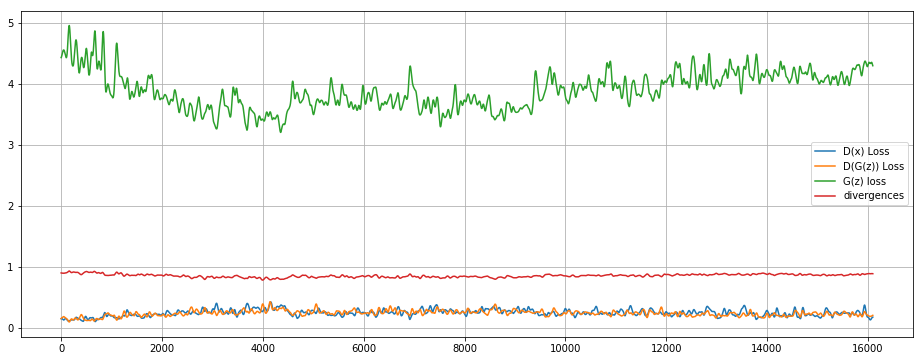

In [243]:
figsize(16, 6)
plot(smooth(d_real_losses), label='D(x) Loss')
plot(smooth(d_fake_losses), label='D(G(z)) Loss')
plot(smooth(g_losses), label='G(z) loss')
plot(smooth(divergences), label='divergences')

grid()
legend()

## Generator Evaluation

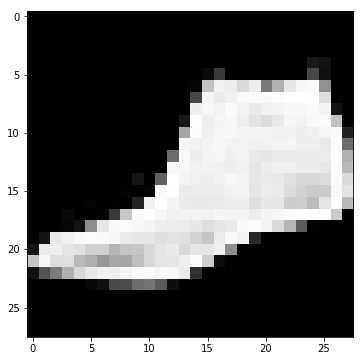

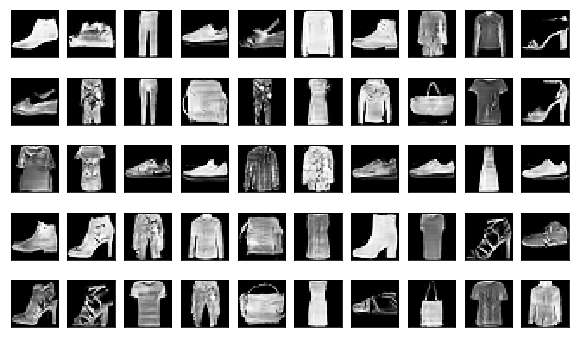

In [275]:
noise = Variable(torch.randn((120, 100)).cuda())
images = 1-G(noise).view((-1, 28, 28)).data.cpu().numpy()

imshow(images[0], cmap=cm.gray_r)

fig, subplots = pylab.subplots(5, 10) # subplots(y축, x축 갯수)
fig.set_figheight(6)
fig.set_figwidth(10)

idx = 0
for _subs in subplots:
    for subplot in _subs:
        d = images[idx]
        subplot.get_xaxis().set_visible(False)
        subplot.get_yaxis().set_visible(False)
        subplot.imshow(d, cmap=cm.gray_r)
        idx += 1

# Estimating Anomaly Score

## Training Latent Space z

In [263]:
noise_optimizer = optim.Adam([noise], lr=0.01)


0.01

[0] loss:32.90028    residual:268.949097 d:6.67259979 noise:-1.41  grad:13.52 lr:0.1
[1000] loss:23.76755333 residual:224.095398 d:1.50890005 noise:5.325  grad:3.909 lr:0.1
[2000] loss:27.81210709 residual:249.520096 d:3.17790008 noise:-33.48  grad:0.1848 lr:0.1
[3000] loss:26.41841316 residual:252.121506 d:1.34029996 noise:-15.56  grad:0.05015 lr:0.1
[4000] loss:8.969367027 residual:63.7663994 d:2.88080001 noise:-9.081  grad:0.0271 lr:0.1
[5000] loss:8.387283325 residual:61.8484001 d:2.44720006 noise:20.13  grad:0.03865 lr:0.1
[6000] loss:2.893482685 residual:25.9822006 d:0.328099996 noise:60.45  grad:0.2994 lr:0.1
[7000] loss:2.125871181 residual:19.9515991 d:0.145199999 noise:90.47  grad:0.7803 lr:0.1
[8000] loss:1.817275524 residual:17.1627998 d:0.112199999 noise:104.7  grad:0.4057 lr:0.1
[9000] loss:1.74808073  residual:16.6443996 d:0.0929000005 noise:114.7  grad:0.5765 lr:0.1
[10000] loss:1.737311125 residual:16.5569992 d:0.0907000005 noise:113.1  grad:0.3719 lr:0.1
[11000] loss:

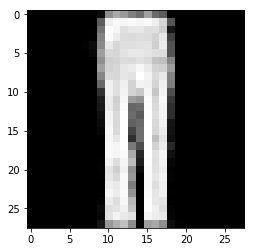

In [265]:
def feature_mapping(G, D, real, fake):
        _, real_fs = D.forward(real, _return_activations=True)
        _, fake_fs = D.forward(fake, _return_activations=True)
        real = real_fs
        fake = fake_fs
        
        diffs = []
        for real, fake in zip(real_fs, fake_fs):
            diff = torch.mean(torch.pow(real - fake, 2))
            diffs.append(diff)
        
        output = torch.mean(torch.stack(diffs))
        return output

def residual_loss(real_y, generated_y):
    return torch.sum(torch.abs(real_y - generated_y))

def anomaly_loss(residual_loss, d_loss, l=0.5):
    return (1 - l) * residual_loss + l * d_loss

def train_latent_space(img_x):
    # Transform Real Image
    img_x = img_x.view(img_x.size(0), 1, img_x.size(-1), img_x.size(-1))
    real_img = Variable(img_x.cuda())
    
    # Define latent space (noise)
    noise = Variable(torch.randn(1, 100).cuda(), requires_grad=True)
    noise_optimizer = optim.Adam([noise], lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(noise_optimizer)
    
    # Train Latent Space z
    for step in range(50000):
        generated_img = G(noise)
        
        loss_r = residual_loss(real_img, generated_img)
        loss_d = feature_mapping(G, D, real_img, generated_img)
        loss_a = anomaly_loss(loss_r, loss_d, l=0.9)
        
        noise_optimizer.zero_grad()
        loss_a.backward(retain_graph=True)
        noise_optimizer.step()
        
        if step%1000 == 0:
            _loss = loss_a.cpu().data.numpy()[0]
            _loss_r = np.round(loss_r.cpu().data.numpy()[0], 4)
            _loss_d = np.round(loss_d.cpu().data.numpy()[0], 4)
            _noise = torch.sum(noise).cpu().data.numpy()[0]
            _noise_max = noise.max()[0].data.cpu().numpy()[0]
            _noise_min = noise.min()[0].data.cpu().numpy()[0]
            _grad = np.sqrt(np.sum(noise.grad.cpu().data.numpy()**2))
            _lr = noise_optimizer.param_groups[0]['lr']
            
            print(f'[{step}] loss:{_loss:<11.10} '
                  f'residual:{_loss_r:<10.9} '
                  f'd:{_loss_d:<10.9} '
                  f'noise:{_noise:.4}  grad:{_grad:.4} '
                  f'lr:{_lr:.4}')
            
            scheduler.step(_loss)
            
    return noise

# sample_x, sample_y = next(iter(train_loader))
noise = train_latent_space(sample_x[0])
imshow(G(noise)[0][0].cpu().data.numpy(), cmap='gray')

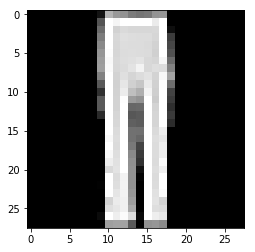

In [257]:
sample_x, sample_y = next(iter(train_loader))
imshow(sample_x[0].cpu().numpy().reshape(28, 28), cmap='gray')

## Visualization

Anomaly Score: 6.4362640380859375


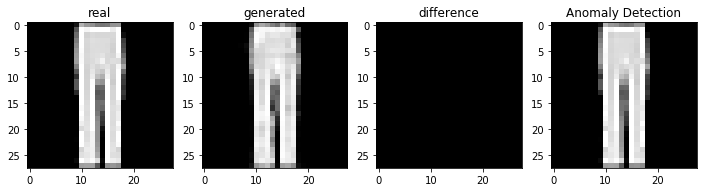

In [266]:
def compare_images(real_img, generated_img):
    real_img = real_img.cpu().data.numpy().reshape(28, 28) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(28, 28) * 255
    generated_img = generated_img.astype(np.uint8)
    
    diff_img = np.abs(real_img - generated_img)
    diff_img[diff_img <= 150] = 0
    
    anomaly_img = np.zeros(shape=(28, 28, 3))
    anomaly_img[:, :, 0] = real_img
    anomaly_img[:, :, 1] = real_img
    anomaly_img[:, :, 2] = real_img
    anomaly_img[:, :, 0] += diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    
    fig, plots = plt.subplots(1, 4)
    fig.set_figwidth(12)
    fig.set_figheight(10)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label='real')
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    

def estimate_anomaly_score(real_img, generated_img):
    real_img = real_img.view(1, 1, 28, 28).cuda()
    generated_img = generated_img.view(1, 1, 28, 28).cuda()

    loss_r = residual_loss(real_img, generated_img)
    loss_d = feature_mapping(G, D, real_img, generated_img)
    loss_a = anomaly_loss(loss_r, loss_d, l=0.5)
    return loss_a.cpu().data.numpy()[0]

real_img = Variable(sample_x[0][0]).cuda()
generated_img = G(noise)[0][0].cuda()
score = anomaly_score(real_img, generated_img)

compare_images(real_img, generated_img)
print(f'Anomaly Score: {score}')